In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
import sys
sys.path.append('../segmention_buildings/BuildFormer')
import matplotlib.pyplot as plt
import json
import sys
from torch  import nn
from tqdm import tqdm
from torch import optim
import torch.nn.functional as F
import cv2
import numpy as np
import kornia as K
import math
from glob import glob
import torch

In [3]:
sys.path.append('/home/wanghaifeng/whf_work/work_sync/vit/vit-pytorch/vit_pytorch')
sys.path.append('/home/wanghaifeng/whf_work/work_sync/satellite_data/models_config/segment-anything/segment_anything')

from init import *
from train_model import train_model
from lossers import dice_loss
from  models import get_model
from lossers import get_loss_function
from datasets import get_dataloader
from geoseg.models.BuildFormer import BuildFormerSegDP
from optimizers_schedulers import get_optimizer_scheduler, update_paramter
from utiles.mask_utles import get_color_mask,mask2color,show_image_mask,show_image_mask_, rgbmask2label,label_colormap, image_diff
from utiles.mask_utles import rgbmask2label,label2rgbmask,rgb2cls_masks,label2rgbmask2,label_colormap
from utiles.tensor2imgmask import *

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
##1. 数据配置
config_path = './model_config/model_vgg_unet_seg_dataset_imgs8.json'
cfg = json.load(open(config_path))
# cfg['data']['dataset']='disaster_dataset'
# cfg['data']['path']=r'./model_config/dataset_config_xBDearthquake.json'
# cfg['data']['n_classes']=3
cfg['training']['batch_size']=1
cfg['training']['img_size']=(1024,1024)

n_classes=cfg['data']['n_classes']
load_weights =''

if not Path(load_weights).exists():
        load_weights=''

# model = get_model(cfg['model'])(3, n_classes)
# model = torch.nn.parallel.DataParallel(model)
# if len(load_weights)>0:
#     print('loading weights',load_weights)
#     model.load_state_dict(torch.load(load_weights, map_location='cpu'))

# optimizer, scheduler = get_optimizer_scheduler(model,cfg)

# get_train_loss_func = get_loss_function(cfg["training"]["loss"].copy())

trainloader, valloader = get_dataloader(cfg)

init dataset:  seg_dataset
----------------------- /home/wanghaifeng/project_work/datasets/disaster_dataset/imgs8
select index: cd_cd_1  index_n: 15
----------------init dataset---------------
loading dataset: /home/wanghaifeng/project_work/datasets/disaster_dataset/imgs8
use subdir: ['t2', 'mask2_2']
dataset size: 680
data_info:
t2 num: 2036
t1 num: 2059
t1_b num: 2059
t2_b num: 2059
mask1 num: 680
mask1_1 num: 2036
mask1_2 num: 0
mask2 num: 2036
mask1_b num: 2059
mask2_b num: 2059
mask1_b1 num: 0
mask2_b1 num: 2059
cd_mask_1 num: 680
mask2_1 num: 2036
mask2_2 num: 2036
cd_cd_1 num: 680
cd_cd num: 680
mask2_b2 num: 0
image num: 0
label num: 0
label_b num: 0
mask_deg_1 num: 0
mask_depth_1 num: 0
mask_deg_2 num: 0
mask_depth_2 num: 0
mask1_3 num: 0
mask2_3 num: 2036
cd_mask_3 num: 680
cd_mask num: 680
------------------------------------------


In [5]:
# model.float().train()
# mask_key=['t1_b','mask1_b1','mask1_2','cd_cd_1','cd_mask_1']
mask_key = cfg['training']['loss']['mask_key']
for i,data in enumerate(trainloader):   
    image_t1   = torch.nn.functional.normalize(data[list(data.keys())[0]].cuda().float())
    # rs = model(image_t1)
    if i==1:
        break

In [6]:
from modeling.image_encoder import ImageEncoderViT
model = ImageEncoderViT(embed_dim=1280,depth=32,num_heads=16,global_attn_indexes=[7,15,23,31],img_size=1024,qkv_bias=True,use_rel_pos=True,window_size=14,out_chans=256)
model.cuda()
print('init model')

init model


In [7]:
sam_checkpoint = "/home/wanghaifeng/whf_work/models/image_encoder.pth"

In [8]:
sam = torch.load(sam_checkpoint,map_location='cpu')
model.load_state_dict(sam)

<All keys matched successfully>

In [10]:
result = model(image_t1)

In [23]:
result.shape

torch.Size([1, 256, 64, 64])

In [16]:
r = result.cpu().numpy()

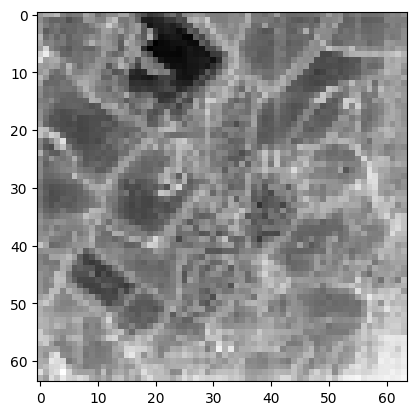

In [22]:
plt.imshow(r[0,9],'gray')

In [57]:
import sys
# sys.path.append(os.getcwd()+'/../models_seg')
sys.path.append(os.getcwd()+'/../satellite_data/valite_dataset_sys')

# from utiles.mask_utles import get_color_mask,mask2color,show_image_mask,show_image_mask_, rgbmask2label,label_colormap, image_diff
# from lib.utils.points_utils import get_sub_label_mask
from lib.utils.mask2svg import mask2pointss,draw_svg_label_color

from skimage import data, exposure

In [ ]:
from glob import glob
img_size = (1024,1024)
imgs_path = glob(r'/home/wanghaifeng/project_work/datasets/disaster_dataset/imgs8/train/t2/*.png')
# imgs_path = glob('/home/wanghaifeng/project_work/datasets/disaster_dataset/harvey/train/t1/*.png')
num_limt = len(imgs_path)
# num_limt = 1
for ni,img_p in enumerate(imgs_path[0:num_limt]):
        img = cv2.imread(img_p)
        if img is None:  continue
        img = cv2.cvtColor(img,cv2.COLOR_RGB2BGR)
        img_orgin = cv2.resize(img,img_size)
        
        img = img_orgin.copy()
        
        mask2_p = img_p.replace('t2','mask2_2')
        if Path(mask2_p).exists():
            mask = cv2.imread(mask2_p)
            mask = cv2.resize(mask, img_size)
        else:
            print("not exists mask==================")
            mask = np.ones(img.shpe)
        
        img = img.transpose(2,0,1)
        img = np.array([img])
        img = torch.from_numpy(img).to(device).float()
        img =torch.nn.functional.normalize(img)

        with torch.no_grad():
            rs = model(img)
            
        img0 = img_orgin.copy()
        mask_label0 = np.zeros(img0.shape,np.uint8)

        mask = mask[:,:,0]
        mask_label0[mask==1]=[0,255,0]
        mask_label0[mask>1]=[255,0,255]

        mask = torch.argmax(rs,1).detach().cpu().numpy()[0]
        img0 = cv2.resize(img_orgin,dsize = mask.shape)
        
        r_mask0 = np.zeros(img0.shape,np.uint8)
        r_mask0[mask==1]=[0,255,0]
        r_mask0[mask==2]=[255,0,255]
        
        r_mask0 = cv2.resize(r_mask0,dsize = img_orgin.shape[:2])
        
        save_path = '/home/wanghaifeng/whf_work/model_works/FPN_foolformer_result_imgs8/'+img_p.split('/')[-1]
        show_image_mask_(mask_label0,img_orgin,n=0.5,save_path=save_path.replace('.png' ,'_gt.png'))
        # show_image_mask_(r_mask0,img0,n=0.5,save_path=save_path.replace('.png' ,'_fix.png'))
        show_image_mask_(r_mask0,img_orgin,n=0.5,save_path=save_path.replace('.png' ,'_pre.png'))
        

/home/wanghaifeng/whf_work/work_sync/models_seg/utiles/mask_utles.py:52: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(20,20))


In [7]:
def mask_pre_2_normal(mask, hull=False,full=False,minpoly=False):
    mask = np.array(mask*255,np.uint8)
    # mask = cv2.dilate(mask, None)
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))
    mask= cv2.dilate(mask, kernel,2)

    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))
    mask= cv2.erode(mask, kernel,2)

    contours, hierarchy = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    contours0=[]
    for contour in contours:
        if cv2.contourArea(contour)>100:
            if hull:contour = cv2.convexHull(contour)
            if minpoly:contour = cv2.approxPolyDP(contour,3,True)
            
            points=[]
            for c in contour[0:]:
                points.append([int(c[0][0]), int(c[0][1])])
            points.append([int(contour[0][0][0]), int(contour[0][0][1])])
            contour = points
            contours0.append(np.array(contour))
       
    if full:
        mask = np.zeros(mask.shape)
        mask = cv2.fillPoly(mask, contours0, 255)
    mask = mask.astype(np.uint8)
    return mask,contours0,contours